# PJT: 금융 CSS(신용평가모델) 개발
이해원

함수 목록
- get_loan_month: 대출기간 전처리
- get_work_year: 근로기간 전처리

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 

plt.rcParams['font.family'] ='D2Coding'

C:\Users\LOVE\AppData\Local\Temp\ipykernel_14368\1903085813.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_df = pd.read_csv('C:/Users/LOVE/Downloads/vscode/CSS/train.csv')
test_df = pd.read_csv('C:/Users/LOVE/Downloads/vscode/CSS/test.csv')

train_df

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [3]:
print(train_df.shape, test_df.shape)

(96294, 15) (64197, 14)


## 1. EDA & 전처리

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


### (1) 기술통계 확인

In [5]:
train_df.describe(include='all')

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
count,96294,9.629400e+04,96294,96294,96294,9.629400e+04,96294.000000,96294.000000,96294,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294
unique,96294,NaN,2,16,4,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,7
top,TRAIN_00000,NaN,36 months,10+ years,MORTGAGE,NaN,NaN,NaN,부채 통합,NaN,NaN,NaN,NaN,NaN,B
freq,1,NaN,64479,31585,47934,NaN,NaN,NaN,55150,NaN,NaN,NaN,NaN,NaN,28817
mean,NaN,1.830400e+07,NaN,NaN,NaN,9.392672e+07,19.379590,25.304827,NaN,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805,NaN
std,NaN,1.032908e+07,NaN,NaN,NaN,9.956871e+07,33.569559,12.088566,NaN,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966,NaN
min,NaN,1.200000e+06,NaN,NaN,NaN,0.000000e+00,0.000000,4.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN
25%,NaN,1.020000e+07,NaN,NaN,NaN,5.760000e+07,12.650000,17.000000,NaN,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000,NaN
50%,NaN,1.680000e+07,NaN,NaN,NaN,7.800000e+07,18.740000,24.000000,NaN,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000,NaN
75%,NaN,2.400000e+07,NaN,NaN,NaN,1.128000e+08,25.540000,32.000000,NaN,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000,NaN


메모
- 범주형
    - 대출기간: 2개(36m, 60m). 'months' 삭제
    - 근로기간: '+', 'years' 등 삭제
    - 주택소유상태: 4개. 원핫인코딩 (행렬로?) ?
    - 대출 목적: 12개. 원핫인코딩 (행렬로?) ? 너무 많은 듯
- 수치형
    - 최근 2년간 연체 횟수: MAX 30, MIN 0, MEAN 0.3, STD 0.9 -> 이상치 확인
    - 총연체금액: MAX 75768, MIN 0, MEAN 54, STD 1414 -> 이상치 확인
    - 연체계좌수: MAX 4, MEAN 0.005, STD 0.079 -> 이상치 확인
- 대출등급
    - 수치형으로 변환?

가설 소스
1. 총계좌수-연체계좌수-대출등급
2. 부채대비소득비율-대출등급
3. 대출금액-연간소득-총상환원금-대출등급

### (2) 범주형 자료 확인 & 변환

In [6]:
for i in train_df[['대출기간', '근로기간', '주택소유상태', '대출목적', '대출등급']].columns:
    print(train_df[i].value_counts())

대출기간
36 months    64479
60 months    31815
Name: count, dtype: int64
근로기간
10+ years    31585
2 years       8450
< 1 year      7774
3 years       7581
1 year        6249
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
10+years       896
<1 year        370
3               89
1 years         56
Name: count, dtype: int64
주택소유상태
MORTGAGE    47934
RENT        37705
OWN         10654
ANY             1
Name: count, dtype: int64
대출목적
부채 통합     55150
신용 카드     24500
주택 개선      6160
기타         4725
주요 구매      1803
의료         1039
자동차         797
소규모 사업      787
이사          506
휴가          466
주택          301
재생 에너지       60
Name: count, dtype: int64
대출등급
B    28817
C    27623
A    16772
D    13354
E     7354
F     1954
G      420
Name: count, dtype: int64


In [7]:
# 대출기간
def get_loan_month(mt):
    return int(mt.strip().replace('months', ''))

train_df['대출기간'] = train_df['대출기간'].apply(get_loan_month)
train_df[['대출기간']]

,대출기간
0,36
1,60
2,36
3,36
4,60
...,...
96289,36
96290,60
96291,36
96292,36


In [8]:
# 근로기간
def get_work_year(yr):
    if yr in ['<1 year', '< 1 year']:
        return 0
    elif yr in ['1 year', '1 years']:
        return 1
    elif yr in ['10+ years', '10+years']:
        return 10
    # 'Unknown'은 NaN으로 대체
    elif yr == 'Unknown':
        return np.nan
    # 그 외는 숫자만 추출
    else:
        return int(''.join(filter(str.isdigit, yr)))

train_df['근로기간'] = train_df['근로기간'].apply(get_work_year)
train_df[['근로기간']]

,근로기간
0,6.0
1,10.0
2,5.0
3,8.0
4,NaN
...,...
96289,10.0
96290,10.0
96291,1.0
96292,5.0


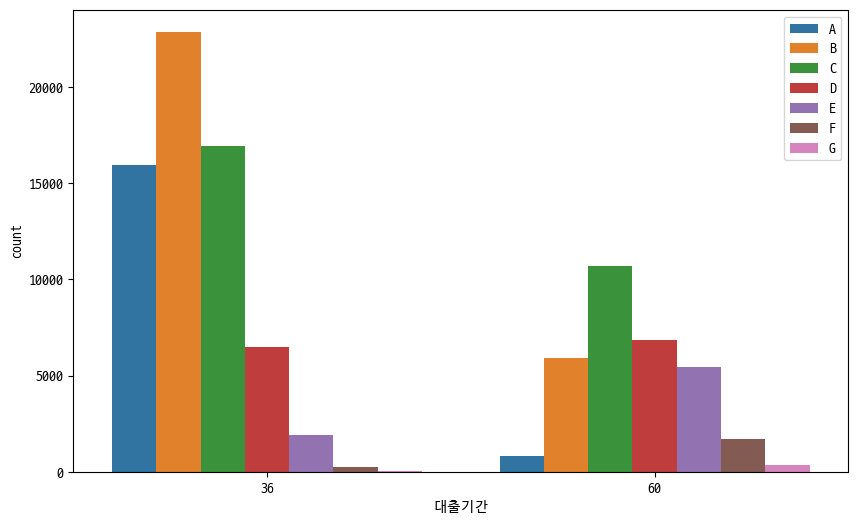

36
대출등급
B    22883
C    16935
A    15952
D     6485
E     1895
F      270
G       59
Name: count, dtype: int64

60
대출등급
C    10688
D     6869
B     5934
E     5459
F     1684
A      820
G      361
Name: count, dtype: int64



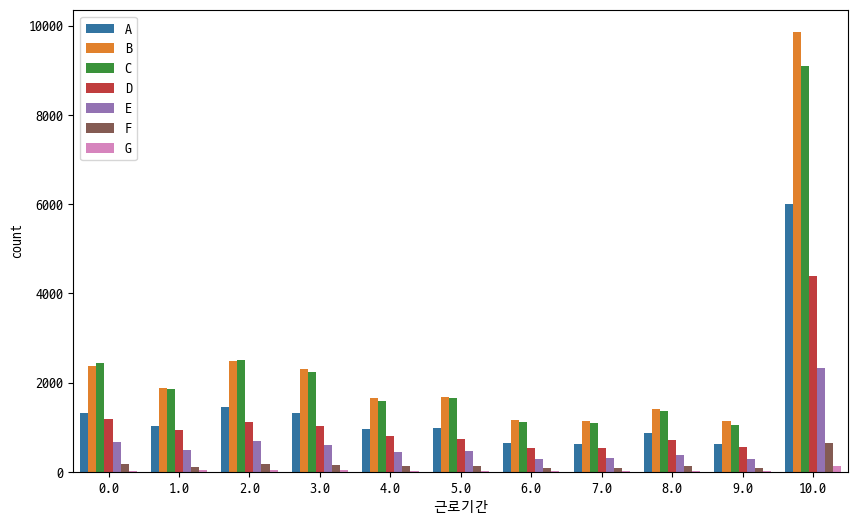

6.0
대출등급
B    1157
C    1124
A     650
D     543
E     296
F      85
G      19
Name: count, dtype: int64

10.0
대출등급
B    9865
C    9105
A    6009
D    4385
E    2331
F     649
G     137
Name: count, dtype: int64

5.0
대출등급
B    1679
C    1646
A     986
D     736
E     475
F     119
G      24
Name: count, dtype: int64

8.0
대출등급
B    1417
C    1364
A     867
D     707
E     385
F     128
G      20
Name: count, dtype: int64

nan
Series([], Name: count, dtype: int64)

9.0
대출등급
B    1137
C    1049
A     621
D     545
E     289
F      85
G      18
Name: count, dtype: int64

2.0
대출등급
C    2495
B    2493
A    1454
D    1107
E     695
F     170
G      36
Name: count, dtype: int64

1.0
대출등급
B    1867
C    1860
A    1031
D     927
E     481
F     110
G      29
Name: count, dtype: int64

3.0
대출등급
B    2302
C    2225
A    1315
D    1028
E     608
F     153
G      39
Name: count, dtype: int64

7.0
대출등급
B    1138
C    1103
A     619
D     535
E     318
F      79
G      22
Name: count, dtype: int64

4.

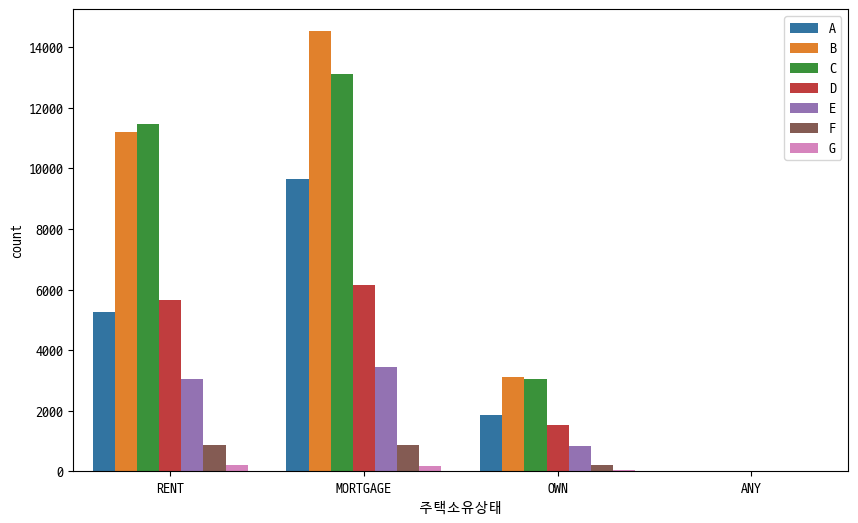

RENT
대출등급
C    11478
B    11200
D     5653
A     5268
E     3056
F      855
G      195
Name: count, dtype: int64

MORTGAGE
대출등급
B    14518
C    13106
A     9640
D     6163
E     3452
F      883
G      172
Name: count, dtype: int64

OWN
대출등급
B    3099
C    3038
A    1864
D    1538
E     846
F     216
G      53
Name: count, dtype: int64

ANY
대출등급
C    1
Name: count, dtype: int64



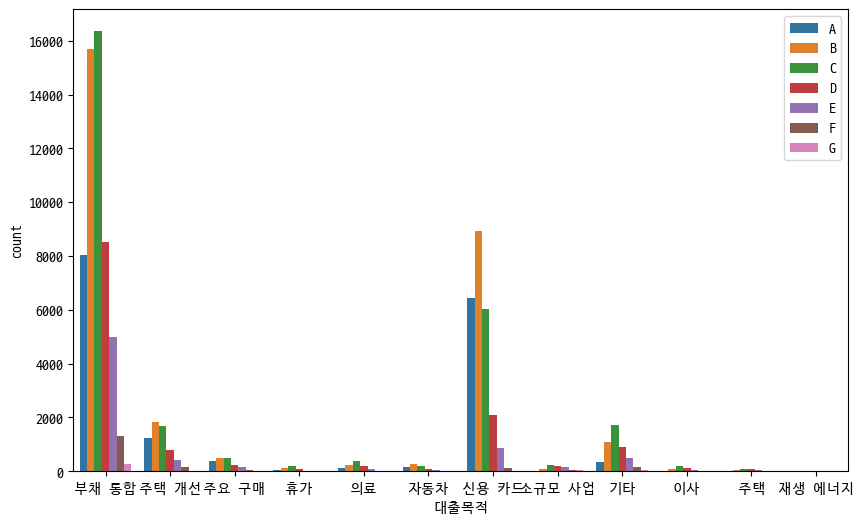

부채 통합
대출등급
C    16349
B    15680
D     8529
A     8036
E     4979
F     1311
G      266
Name: count, dtype: int64

주택 개선
대출등급
B    1845
C    1689
A    1225
D     805
E     425
F     145
G      26
Name: count, dtype: int64

주요 구매
대출등급
C    503
B    479
A    372
D    238
E    150
F     53
G      8
Name: count, dtype: int64

휴가
대출등급
C    196
B    119
D     78
A     40
E     27
F      4
G      2
Name: count, dtype: int64

의료
대출등급
C    375
B    238
D    197
A    104
E     91
F     27
G      7
Name: count, dtype: int64

자동차
대출등급
B    258
C    213
A    174
D     87
E     46
F     15
G      4
Name: count, dtype: int64

신용 카드
대출등급
B    8917
A    6424
C    6036
D    2092
E     877
F     137
G      17
Name: count, dtype: int64

소규모 사업
대출등급
C    249
D    192
E    158
B     75
F     64
G     30
A     19
Name: count, dtype: int64

기타
대출등급
C    1705
B    1080
D     916
E     478
A     356
F     147
G      43
Name: count, dtype: int64

이사
대출등급
C    203
D    131
B     86
E     50
F     18
A     13
G   

In [9]:
# 시각화
ctgr_list = ['대출기간', '근로기간', '주택소유상태', '대출목적']

def ctgr_value_counts(iumn_name):
    for uniq in list(train_df[iumn_name].unique()):
        cond_unique = (train_df[iumn_name]==uniq)
        print(uniq)
        print(train_df.loc[cond_unique]['대출등급'].value_counts())
        print()

for i in ctgr_list:
    plt.figure(figsize=(10,6))
    sns.countplot(data=train_df, x=i, hue='대출등급', hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])     
    plt.legend(loc='best')
    plt.show()
    ctgr_value_counts(iumn_name=i)

### (3) 수치형 자료 확인 & 변환

In [10]:
train_df.describe()

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,96294.000000,90623.000000,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,43.929466,6.007791,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,11.288582,3.728511,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,36.000000,0.000000,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,36.000000,2.000000,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,36.000000,6.000000,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,60.000000,10.000000,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,60.000000,10.000000,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


# 

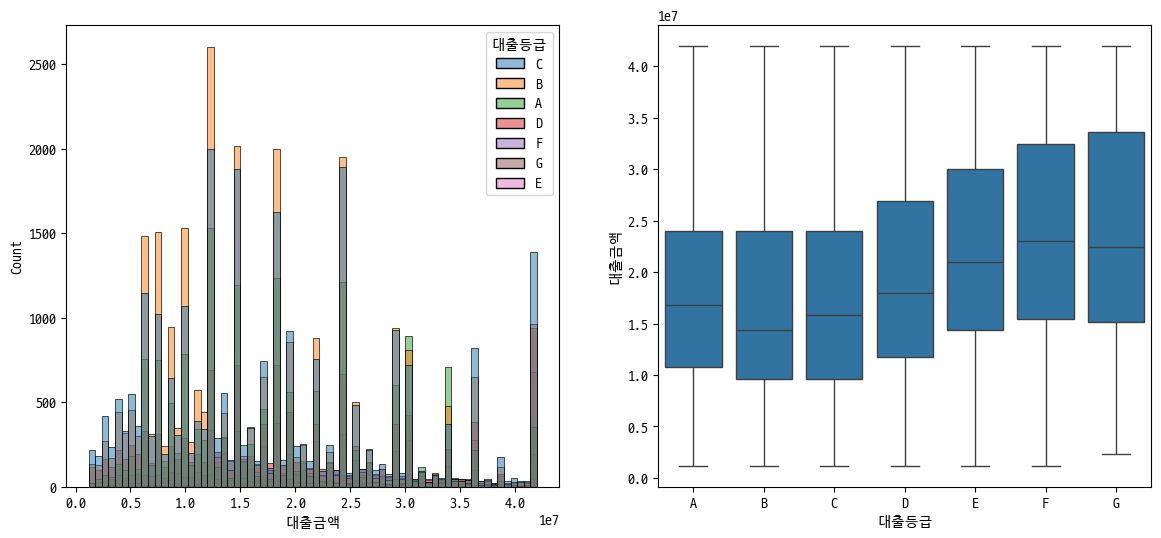

,mean,std,min,25%,50%,75%,max
A,1.790579e+07,9.294000e+06,1200000.0,10800000.0,16800000.0,24000000.0,42000000.0
B,1.686808e+07,9.772310e+06,1200000.0,9600000.0,14400000.0,24000000.0,42000000.0
C,1.789004e+07,1.052509e+07,1200000.0,9600000.0,15840000.0,24000000.0,42000000.0
D,1.953331e+07,1.097276e+07,1200000.0,11730000.0,18000000.0,26880000.0,42000000.0
E,2.232013e+07,1.077465e+07,1200000.0,14340000.0,21000000.0,30000000.0,42000000.0
F,2.400517e+07,1.061245e+07,1200000.0,15480000.0,23040000.0,32422500.0,42000000.0
G,2.402079e+07,1.080393e+07,2310000.0,15120000.0,22440000.0,33600000.0,42000000.0


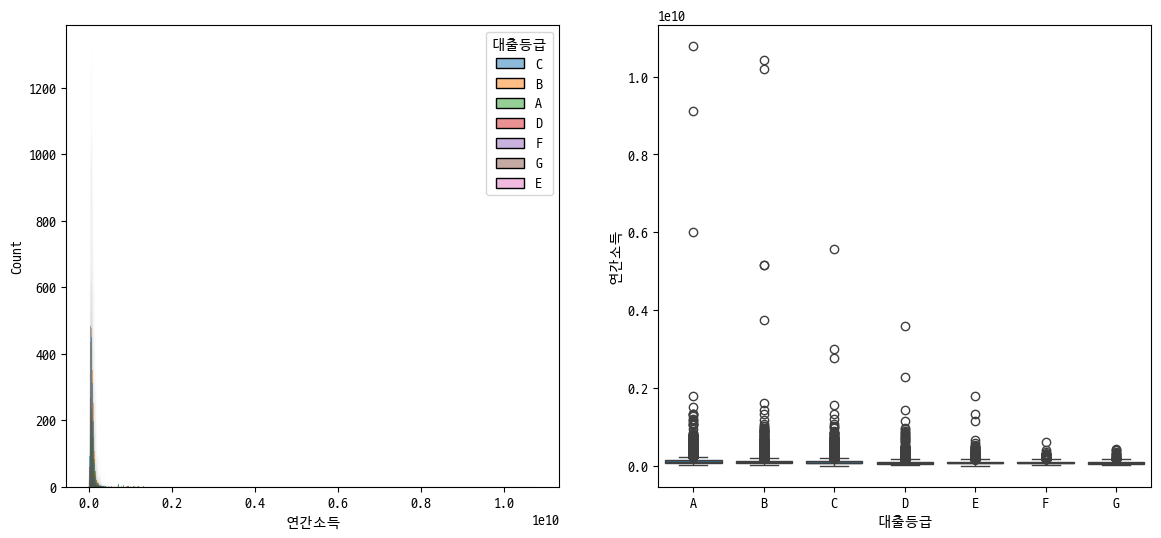

,mean,std,min,25%,50%,75%,max
A,1.124911e+08,1.396115e+08,11424000.0,67200000.0,96000000.0,132000000.0,1.080000e+10
B,9.570640e+07,1.160385e+08,9600000.0,58386000.0,81600000.0,114000000.0,1.044000e+10
C,8.903804e+07,7.227919e+07,0.0,54000000.0,75600000.0,108000000.0,5.576640e+09
D,8.359673e+07,6.622318e+07,2124000.0,51454800.0,72000000.0,100800000.0,3.600000e+09
E,8.492864e+07,5.582495e+07,1440000.0,54000000.0,73200000.0,102000000.0,1.800000e+09
F,8.434506e+07,4.500624e+07,10627200.0,54000000.0,75430800.0,102000000.0,6.000000e+08
G,8.258034e+07,5.407082e+07,10555200.0,50400000.0,70800000.0,96000000.0,4.344000e+08


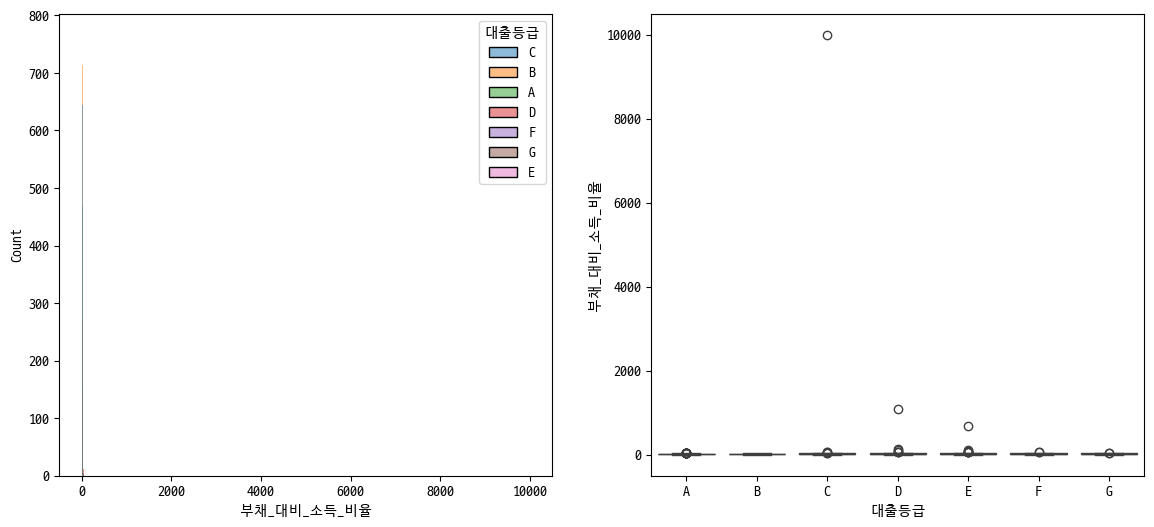

,mean,std,min,25%,50%,75%,max
A,16.547850,7.558913,0.00,10.8200,16.130,21.8700,39.80
B,18.129529,8.191684,0.00,11.9300,17.600,23.9800,41.69
C,20.270095,60.681872,0.00,13.3000,19.510,26.3050,9999.00
D,21.808465,13.166067,0.00,14.6900,21.610,29.1575,1092.52
E,22.248466,11.977395,0.16,15.3500,21.925,29.2875,672.52
F,21.853710,8.913153,0.66,15.3925,22.125,28.3375,54.36
G,20.691952,8.718104,0.82,14.3525,21.095,26.5350,47.61


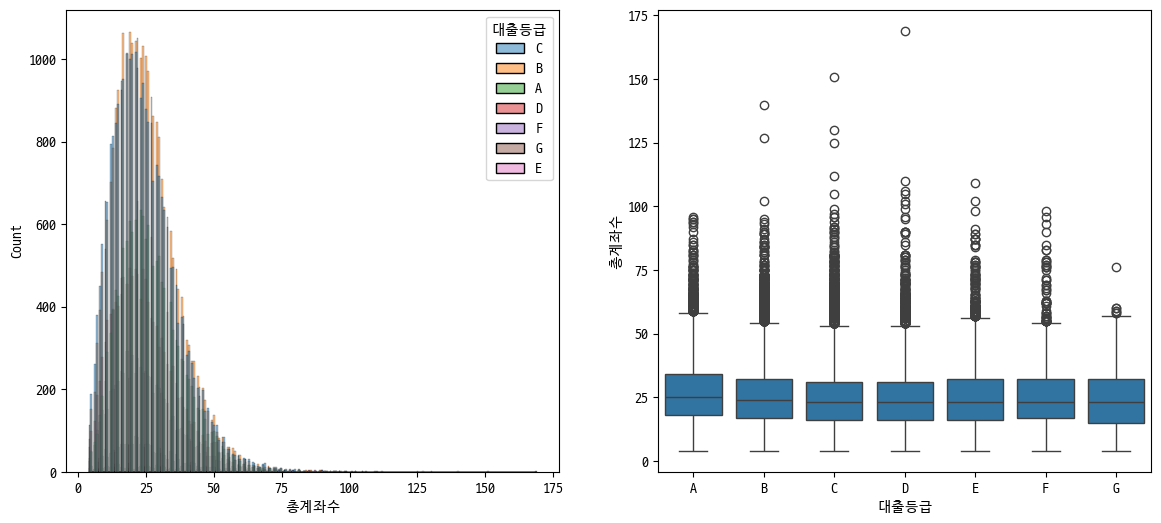

,mean,std,min,25%,50%,75%,max
A,26.910684,11.788615,4.0,18.0,25.0,34.0,96.0
B,25.223375,11.765557,4.0,17.0,24.0,32.0,140.0
C,24.695073,12.195646,4.0,16.0,23.0,31.0,151.0
D,24.705107,12.357153,4.0,16.0,23.0,31.0,169.0
E,25.320642,12.522195,4.0,16.0,23.0,32.0,109.0
F,25.543501,12.950036,4.0,17.0,23.0,32.0,98.0
G,24.550000,12.482346,4.0,15.0,23.0,32.0,76.0


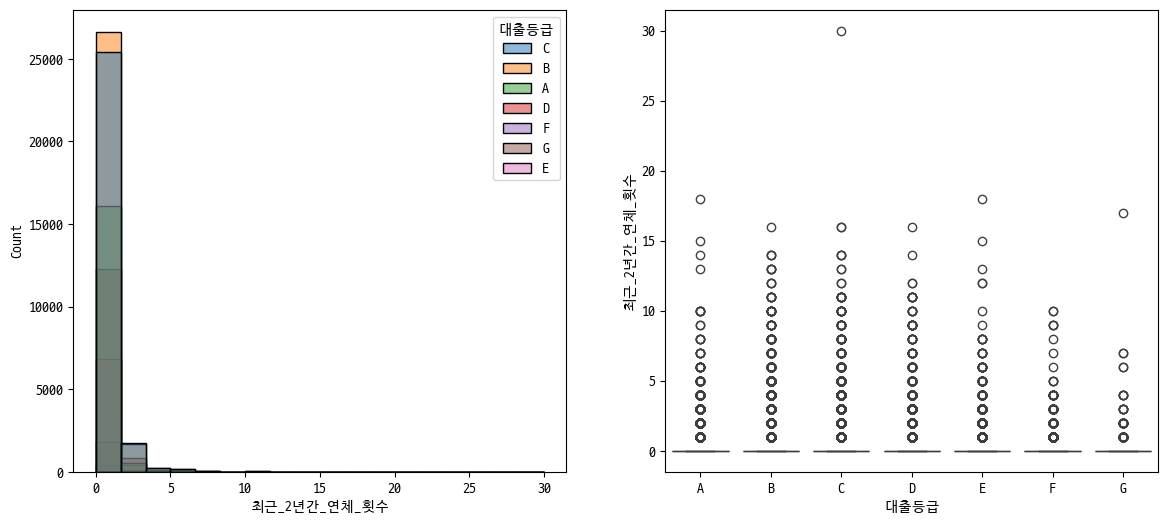

,mean,std,min,25%,50%,75%,max
A,0.218698,0.704163,0.0,0.0,0.0,0.0,18.0
B,0.365409,0.947582,0.0,0.0,0.0,0.0,16.0
C,0.380299,0.966606,0.0,0.0,0.0,0.0,30.0
D,0.384379,0.970777,0.0,0.0,0.0,0.0,16.0
E,0.349334,0.914513,0.0,0.0,0.0,0.0,18.0
F,0.361822,0.914466,0.0,0.0,0.0,0.0,10.0
G,0.416667,1.239835,0.0,0.0,0.0,0.0,17.0


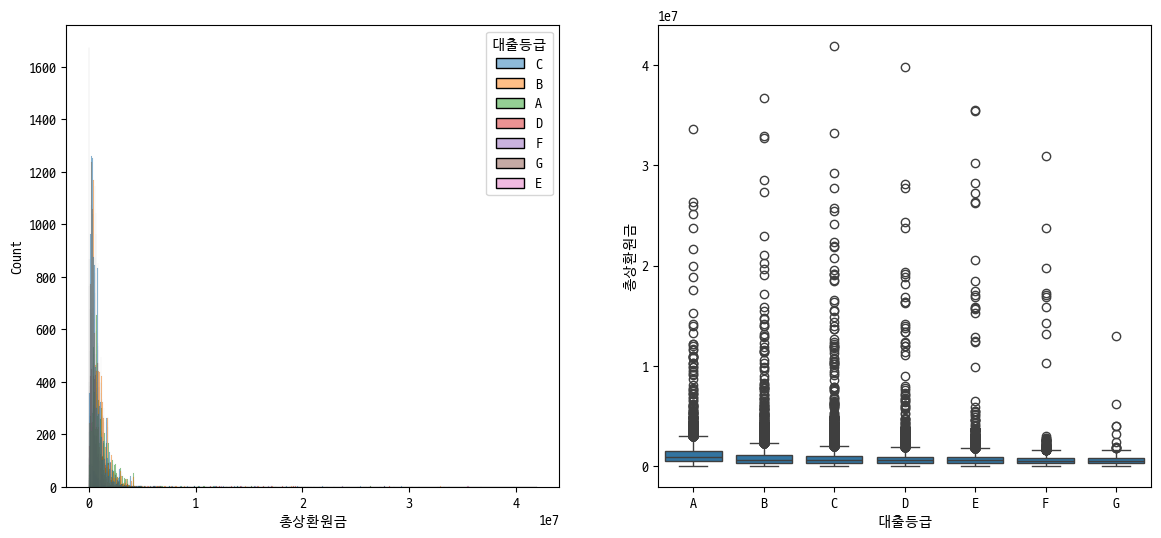

,mean,std,min,25%,50%,75%,max
A,1.066966e+06,1.076776e+06,0.0,444804.0,830280.0,1441248.0,33683988.0
B,8.340144e+05,9.403085e+05,0.0,318336.0,606564.0,1101888.0,36721164.0
C,7.521078e+05,9.753910e+05,0.0,278616.0,552132.0,963672.0,41955936.0
D,7.297173e+05,1.018910e+06,0.0,267948.0,528600.0,908784.0,39793896.0
E,7.074507e+05,1.238723e+06,0.0,288672.0,523908.0,872802.0,35550000.0
F,6.673177e+05,1.368616e+06,0.0,267030.0,490224.0,794940.0,30911292.0
G,5.870190e+05,8.149610e+05,0.0,229296.0,442188.0,764745.0,12937416.0


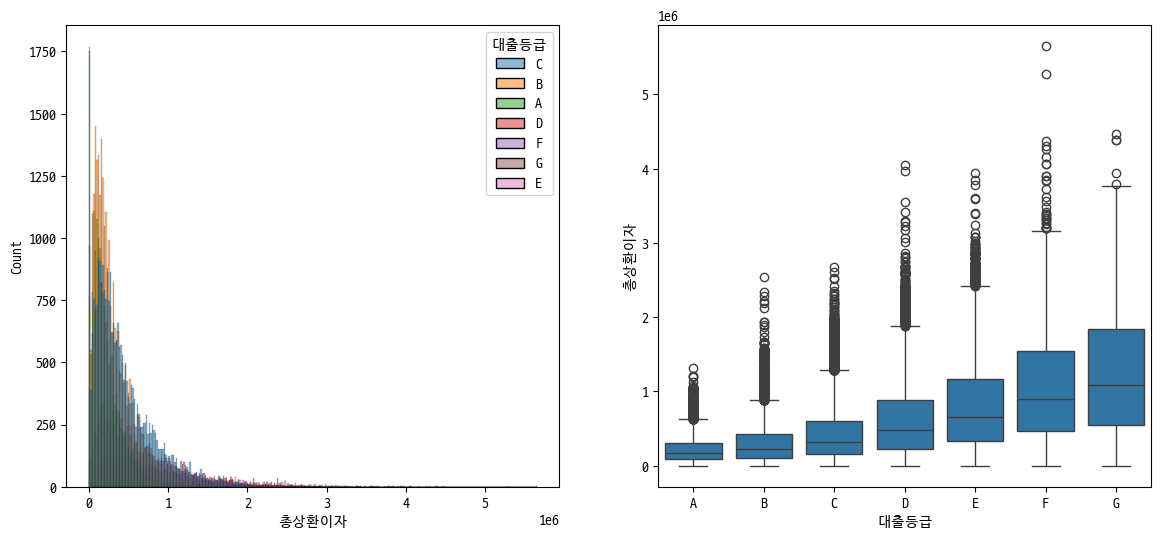

,mean,std,min,25%,50%,75%,max
A,2.240085e+05,183508.609726,0.0,91401.0,175632.0,306678.0,1315908.0
B,3.033410e+05,268912.292532,0.0,110652.0,222228.0,421008.0,2538084.0
C,4.306745e+05,377468.910481,0.0,154560.0,323028.0,607092.0,2671956.0
D,6.117896e+05,520056.028372,0.0,220875.0,474684.0,884532.0,4048740.0
E,8.146975e+05,627671.231203,0.0,338886.0,653004.0,1168896.0,3942252.0
F,1.095274e+06,819704.001437,0.0,470883.0,900930.0,1548396.0,5653416.0
G,1.284655e+06,952955.115509,0.0,549405.0,1089972.0,1844562.0,4464612.0


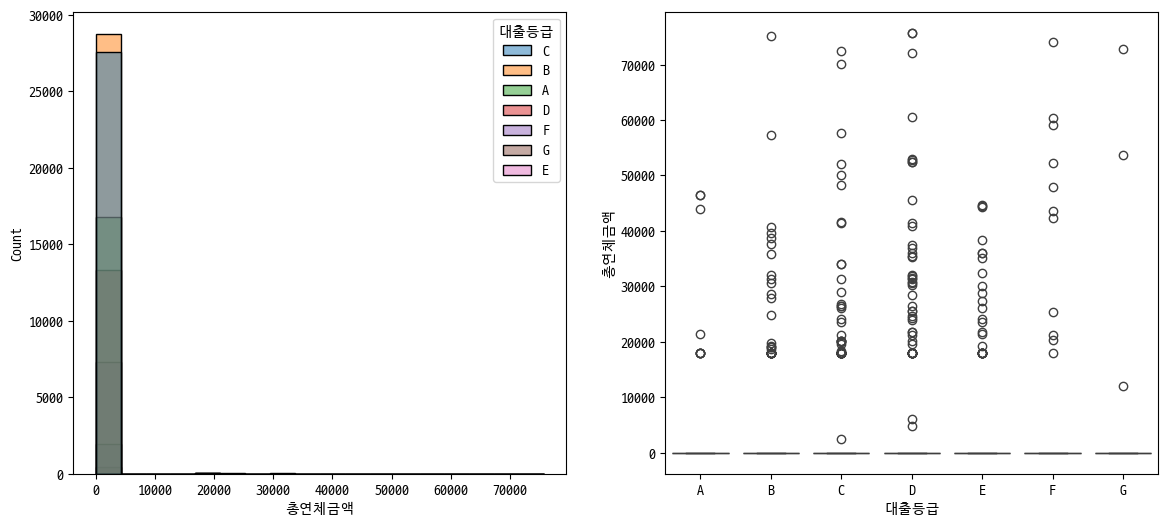

,mean,std,min,25%,50%,75%,max
A,14.806105,704.850463,0.0,0.0,0.0,0.0,46536.0
B,29.441371,983.715162,0.0,0.0,0.0,0.0,75216.0
C,48.052565,1258.793440,0.0,0.0,0.0,0.0,72444.0
D,113.352104,2127.823877,0.0,0.0,0.0,0.0,75768.0
E,94.572206,1678.616326,0.0,0.0,0.0,0.0,44688.0
F,237.801433,3437.789928,0.0,0.0,0.0,0.0,74076.0
G,329.942857,4448.705070,0.0,0.0,0.0,0.0,72864.0


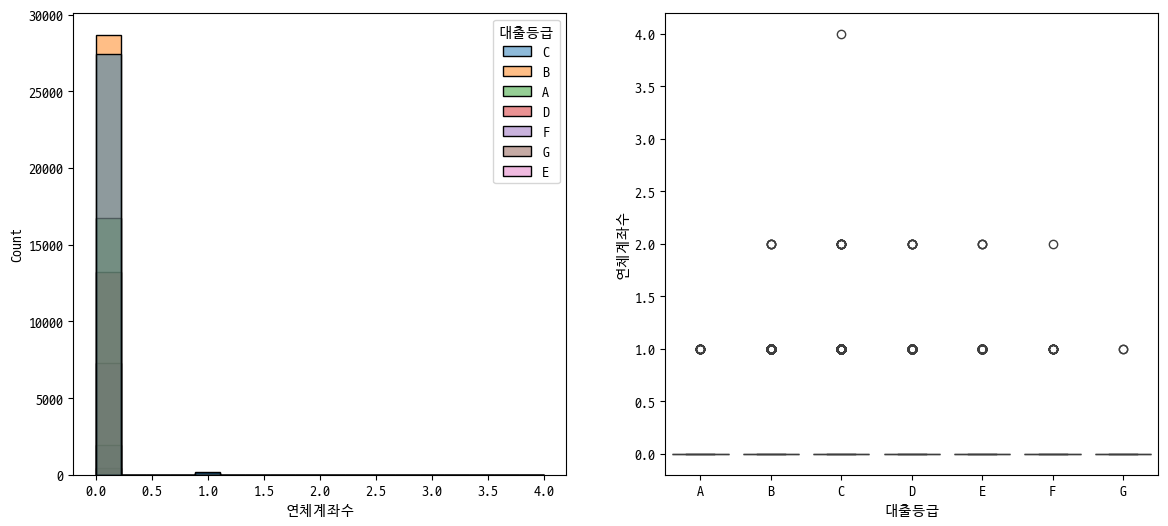

,mean,std,min,25%,50%,75%,max
A,0.001133,0.033640,0.0,0.0,0.0,0.0,1.0
B,0.004789,0.071019,0.0,0.0,0.0,0.0,2.0
C,0.007892,0.094808,0.0,0.0,0.0,0.0,4.0
D,0.008462,0.096382,0.0,0.0,0.0,0.0,2.0
E,0.007615,0.091509,0.0,0.0,0.0,0.0,2.0
F,0.006653,0.087385,0.0,0.0,0.0,0.0,2.0
G,0.004762,0.068924,0.0,0.0,0.0,0.0,1.0


In [23]:
num_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G']

def num_statistic(data, col):
    statistic_df = pd.DataFrame()

    for level in hue_order:
        level_df = data.loc[(data['대출등급']==level)][[col]].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        level_df.index = [level]
        
        statistic_df = pd.concat([statistic_df, level_df], axis=0)

    display(statistic_df)
    print()

for col in num_list:
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
    sns.histplot(data=train_df, x=col, hue='대출등급', ax=ax[0])
    sns.boxplot(data=train_df, y=col, x='대출등급', order=hue_order, ax=ax[1])
    plt.show()
    num_statistic(train_df, col)

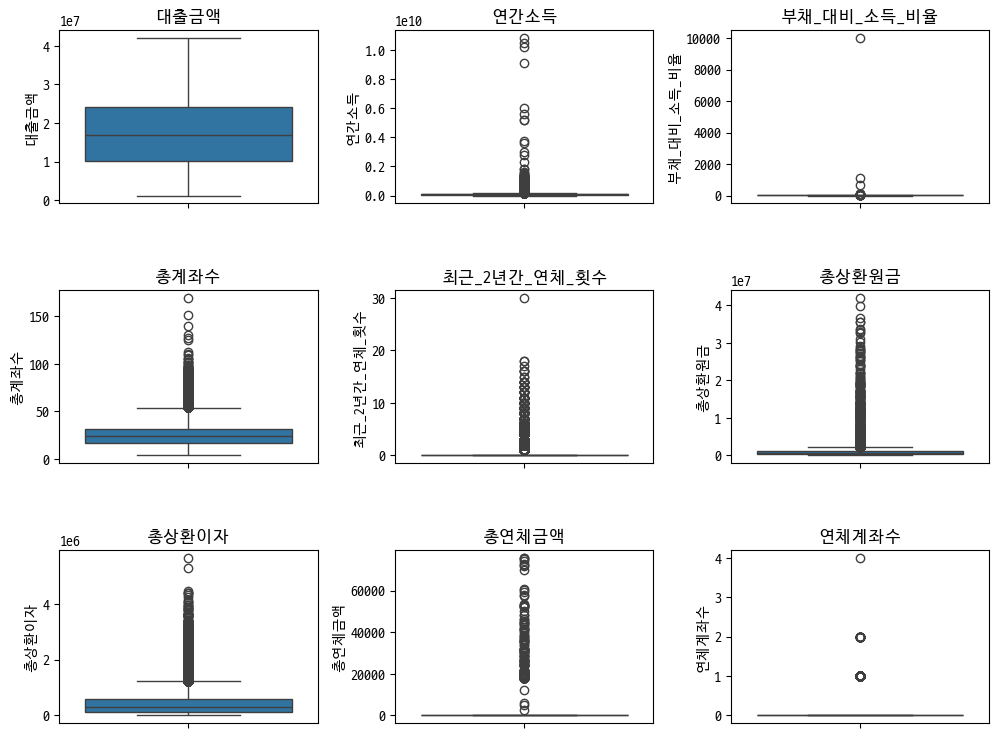

In [22]:
# 이상치 확인
num_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

f, ax = plt.subplots(3, 3, figsize = (12,9))
i = 0
for row in range(3):
    for col in range(3):
        sns.boxplot(train_df, y = num_list[i], ax = ax[row, col])
        ax[row, col].set_title(num_list[i])
        i += 1

plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
plt.show()